# Data prep

The distribution of authors in our dataset. 

In [4]:
import pandas as pd
import random

random.seed(42)

df = pd.read_csv("data.csv")
print(df["author"].value_counts())

/tmp/ipykernel_1469022/3253427203.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


author
reddit    800
bard      800
gpt       800
0.8       200
1.4       200
1.3       200
1.2       200
1.1       200
1.0       200
0.9       200
0.7       200
0.6       200
0.5       200
0.4       200
0.3       200
0.2       200
0.1       200
1.5       200
Name: count, dtype: int64


# Classification

## Pipeline

- `get_tvt_split` - creates a train, validation, test split based on the 10 prompts. A random selection of 2 prompts are used for test, and the other 8 are divided into groups of 2 and used for 4-fold cross validation. The function returns the train dataset, the test dataset, and indices used cross validation. 

- `get_best_params` - uses grid search to find the best hyperparameters for the Logistic Regression model. 

- `expand_df` creates a new dataframe with just the given vectors (e.g. ["bert", "common"])

- `classify` - given authors to classify and vectors to use, it the following `n_trials` (default=20) times, returning the accuracy and f1 score of each trial: it uses `get_tvt_split` to generate train, validation, and test split, then uses `get_best_params` to construct a Logistic Regression model with performant hyperparameters that it uses to evaluate the model on the test set. It creates a balanced dataset by using the minimum number of samples from the set of given authors.

In [6]:
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler


def get_tvt_split(df_cur: pd.DataFrame):
    grouped_indices = (
        df_cur.groupby("prompt")
        .apply(lambda x: x.index.tolist(), include_groups=False)
        .tolist()
    )

    random.shuffle(grouped_indices)

    test_indices = np.concatenate(grouped_indices[:2])

    df_cur_test = df_cur.loc[test_indices]
    df_cur_train = df_cur.drop(test_indices).reset_index(drop=True)

    grouped_indices_train = (
        df_cur_train.groupby("prompt")
        .apply(lambda x: x.index.tolist(), include_groups=False)
        .tolist()
    )

    cv_iterable = []
    for _ in range(4):
        grouped_indices_train = grouped_indices_train[2:] + grouped_indices_train[:2]
        val_indices = np.concatenate(grouped_indices_train[:2])
        train_indices = np.concatenate(grouped_indices_train[2:])
        cv_iterable.append((train_indices, val_indices))

    return df_cur_train, df_cur_test, cv_iterable


def get_best_params(X_train, y_train, cv_iterable):
    param_grid = {
        "C": [0.1, 0.3, 1, 3, 10],
        "solver": ["liblinear", "lbfgs"],
    }

    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        param_grid,
        cv=cv_iterable,
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_params_


def expand_df(df, vector_names):
    df_columns = []
    for column in vector_names:
        df_column = df[column].apply(ast.literal_eval).apply(pd.Series)
        df_columns.append(df_column)
    return pd.concat(df_columns, axis=1)


def classify(authors, vector_names, n_trials=20):
    accuracies = []
    f1s = []

    for random_state in range(n_trials):
        max_samples = min(df["author"].value_counts()[authors])
        df_authors = pd.concat(
            [df[df["author"] == author].sample(max_samples) for author in authors]
        ).reset_index(drop=True)

        df_train, df_test, cv_iterable = get_tvt_split(df_authors)

        X_train = expand_df(df_train, vector_names)
        y_train = df_train["author"]
        X_test = expand_df(df_test, vector_names)
        y_test = df_test["author"]

        standardizer = StandardScaler()
        X_train = standardizer.fit_transform(X_train)
        X_test = standardizer.transform(X_test)

        best_params = get_best_params(X_train, y_train, cv_iterable)
        model = LogisticRegression(
            **best_params,
            max_iter=1000,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        f1 = f1_score(y_test, y_pred, average="weighted")
        f1s.append(f1)

    return accuracies, f1s

## Reddit, GPT

The 5 sets of vectors we use for classification are:

In [8]:
list_of_vector_names = [
    (["common"], "c"),
    (["function"], "f"),
    (["common", "function"], "cf"),
    (["bert"], "b"),
    (["common", "function", "bert"], "cfb"),
]

### GPT temp = Ben's chosen (default?)

800 reddit, 800 GPT

In [38]:
for vector_names in list_of_vector_names:
    accuracies, f1s = classify(["reddit", "gpt"], vector_names)
    print(
        f"{vector_names} accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}, f1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    )

['common'] accuracy: 0.798 ± 0.104, f1: 0.786 ± 0.117
['function'] accuracy: 0.797 ± 0.141, f1: 0.791 ± 0.146
['common', 'function'] accuracy: 0.773 ± 0.176, f1: 0.765 ± 0.183
['bert'] accuracy: 0.963 ± 0.026, f1: 0.963 ± 0.026
['common', 'function', 'bert'] accuracy: 0.979 ± 0.029, f1: 0.979 ± 0.030


### GPT temp $\in [0.1,...,1.5]$

For each of the 15 temperature values: 200 reddit, 200 GPT

In [ ]:
from tqdm import tqdm

results_df = pd.DataFrame()
temps = [f"{temp:.1f}" for temp in np.linspace(0.1, 1.5, 15)]

for temp in tqdm(temps):
    for vector_names, vector_name_str in list_of_vector_names:
        accuracies, f1s = classify(["reddit", temp], vector_names)
        for accuracy, f1 in zip(accuracies, f1s):
            new_row = pd.DataFrame(
                {
                    "temp": temp,
                    "vector_name_str": vector_name_str,
                    "accuracy": accuracy,
                    "f1": f1,
                },
                index=[0],
            )
            results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_csv("results/classification_15_temps.csv", index=False)

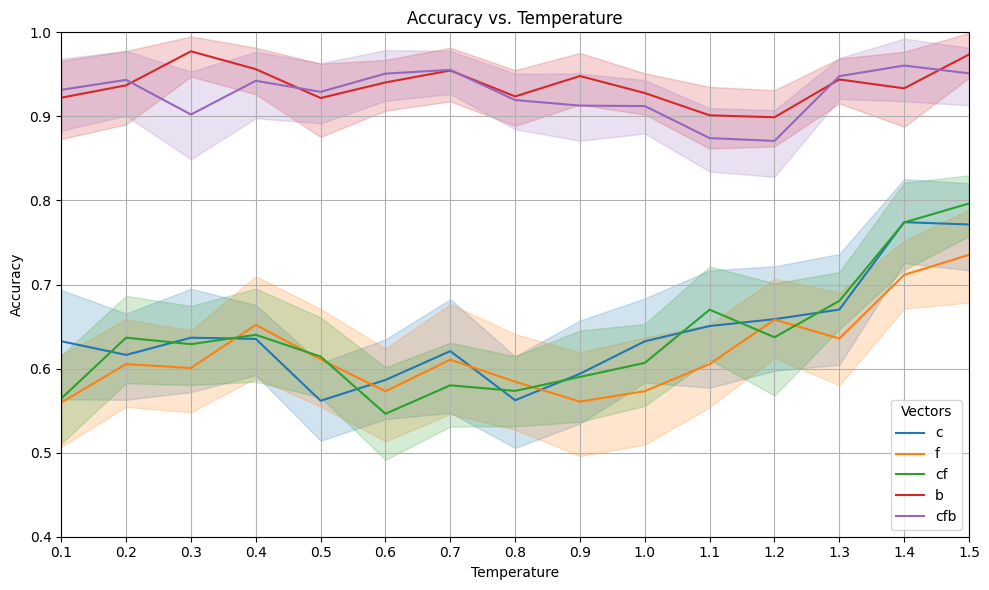

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt


results_df = pd.read_csv("results/classification_15_temps.csv")

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="temp", y="accuracy", hue="vector_name_str")
plt.xlabel("Temperature")
plt.xticks([float(temp) for temp in temps])
plt.xlim(0.1, 1.5)
plt.ylim(0.4, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Temperature")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Vectors", loc="lower right")
plt.show()

## Reddit, Bard

800 reddit, 800 Bard

In [34]:
for vector_names, vector_name_str in list_of_vector_names:
    accuracies, f1s = classify(["reddit", "bard"], vector_names)
    print(
        f"{vector_names} accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}, f1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    )

['common'] accuracy: 0.842 ± 0.090, f1: 0.840 ± 0.092
['function'] accuracy: 0.825 ± 0.054, f1: 0.823 ± 0.055
['common', 'function'] accuracy: 0.812 ± 0.062, f1: 0.809 ± 0.064
['bert'] accuracy: 0.980 ± 0.024, f1: 0.980 ± 0.025
['common', 'function', 'bert'] accuracy: 0.990 ± 0.008, f1: 0.990 ± 0.008


## Bard, GPT (temp = Ben's chosen)

800 Bard, 800 GPT

In [35]:
for vector_names, vector_name_str in list_of_vector_names:
    accuracies, f1s = classify(["bard", "gpt"], vector_names)
    print(
        f"{vector_names} accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}, f1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    )

['common'] accuracy: 0.850 ± 0.119, f1: 0.849 ± 0.121
['function'] accuracy: 0.841 ± 0.109, f1: 0.839 ± 0.111
['common', 'function'] accuracy: 0.851 ± 0.117, f1: 0.851 ± 0.118
['bert'] accuracy: 0.988 ± 0.014, f1: 0.988 ± 0.014
['common', 'function', 'bert'] accuracy: 0.988 ± 0.013, f1: 0.988 ± 0.013


# Trinary Classification (GPT, Bard, Reddit (temp = Ben's chosen))

800 GPT, 800 Bard, 800 Reddit

In [38]:
for vector_names, vector_name_str in list_of_vector_names:
    accuracies, f1s = classify(["gpt", "bard", "reddit"], vector_names)
    print(
        f"{vector_name_str}\t accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}, f1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    )

c	 accuracy: 0.706 ± 0.147, f1: 0.699 ± 0.160
f	 accuracy: 0.743 ± 0.070, f1: 0.738 ± 0.070
cf	 accuracy: 0.723 ± 0.079, f1: 0.719 ± 0.080
b	 accuracy: 0.955 ± 0.026, f1: 0.955 ± 0.026
cfb	 accuracy: 0.970 ± 0.017, f1: 0.970 ± 0.017


# Examples between GPT and Reddit (Ben's default)


1. Where CF, Bert classification both get it right
2. Where they both get it wrong
3. Where CF get it right and Bert gets it wrong
4. Vise versa

In [22]:
authors = ["gpt", "reddit"]
max_samples = min(df["author"].value_counts()[authors])
df_authors = pd.concat(
    [df[df["author"] == author].sample(max_samples) for author in authors]
).reset_index(drop=True)

df_train, df_test, cv_iterable = get_tvt_split(df_authors)

bert_correct_indices = []
bert_incorrect_indices = []
cf_correct_indices = []
cf_incorrect_indices = []

for vector_names in [["bert"], ["common", "function"]]:

    X_train = expand_df(df_train, vector_names)
    y_train = df_train["author"]
    X_test = expand_df(df_test, vector_names)
    y_test = df_test["author"]

    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    best_params = get_best_params(X_train, y_train, cv_iterable)
    model = LogisticRegression(
        **best_params,
        max_iter=1000,
        random_state=42,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    correct_indices = df_test.index[y_pred == y_test]
    incorrect_indices = df_test.index[y_pred != y_test]

    if vector_names == ["bert"]:
        bert_correct_indices = correct_indices
        bert_incorrect_indices = incorrect_indices
    else:
        cf_correct_indices = correct_indices
        cf_incorrect_indices = incorrect_indices

print(
    "Number of indices where both BERT and CF were correct:",
    len(set(bert_correct_indices) & set(cf_correct_indices)),
)

print(
    "Number of indices where both BERT and CF were incorrect:",
    len(set(bert_incorrect_indices) & set(cf_incorrect_indices)),
)

print(
    "Number of indices where BERT was incorrect and CF was correct:",
    len(set(bert_incorrect_indices) & set(cf_correct_indices)),
)

print(
    "Number of indices where BERT was correct and CF was incorrect:",
    len(set(bert_correct_indices) & set(cf_incorrect_indices)),
)

Number of indices where both BERT and CF were correct: 251
Number of indices where both BERT and CF were incorrect: 0
Number of indices where BERT was incorrect and CF was correct: 8
Number of indices where BERT was correct and CF was incorrect: 61


In [24]:
print("bert and cf were both right")
print(
    df_test.loc[list(set(bert_correct_indices) & set(cf_correct_indices))][
        "response"
    ].iloc[0],
    "\n",
)

# empty set!
# print(df_test.loc[list(set(bert_incorrect_indices) & set(cf_incorrect_indices))]["response"].iloc[0])

print("bert was wrong and cf was right")
print(
    df_test.loc[list(set(bert_incorrect_indices) & set(cf_correct_indices))][
        "response"
    ].iloc[0],
    "\n",
)

print("bert was right and cf was wrong")
print(
    df_test.loc[list(set(bert_correct_indices) & set(cf_incorrect_indices))][
        "response"
    ].iloc[0],
    "\n",
)

bert and cf were both right
I was riding in the train towards the facility and my heart was pounding . I could n't believe it - working for this company was all I ever wanted . Sure , all my peers and professors at Harvard thought I was insane to want to join this group in particular - ' A bunch of mad scientists ' my physics teacher would always say . But they paid an incredible amount compared to what what anyone else in my field paid and that was n't counting health and social benefits - I 'd be able to pay my entire tuition costs in 6 months . Too bad this was only a job interview ... -- - My leg was shattered , my arm was badly cut up and , if I was n't mistaken , the damage to my throat would render me permanently unable to speak . Yet , as the robotic hand lifted the remains of the giant ant off of me , I felt far more invigorated than even when my acceptance letters from all the Ivy League colleges arrived during the Summer after I graduated High School . `` Are you okay ? `` h

All responses where cf was right and bert was wrong

In [25]:
for index in list(set(bert_incorrect_indices) & set(cf_correct_indices)):
    print(df_test.loc[index]["response"], "\n")

`` I love you `` she said , tears streaming from her eyes . He was starting to drift away . He opened his mouth to speak , and she put her finger to his lips . `` I know . Do n't try to talk , just relax . It wo n't be long now . `` She pressed her forehead to his and gripped his hand tightly . - `` I love you `` she said , as she relaxed her grip on the hilt of the knife . She clasped his hand in hers , after wiping off the blood onto his shirt . He opened his mouth to speak , but instead coughed up blood . She held her hand to his mouth . `` Quiet . It 's over . Just let it come . `` The look of confusion in his eyes was starting to fade away , as they began to lose focus and glaze over . 

`` Oh , really ? And what makes you so sure ? `` Emma responded playfully . Max 's breath caught in his chest . He looked back at her incredulously , waves of hurt and shock sweeping across his face like darkness across the twilight sky . This was supposed to be it . This night , this restaurant ,